In [ ]:
import kagglehub
import os

# Download dataset
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
data_dir = path + "/chest_xray"

# Check folders
print("Dataset folders:", os.listdir(data_dir))
for split in ['train','val','test']:
    print(split, os.listdir(os.path.join(data_dir,split)))

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Dataset folders: ['chest_xray', '__MACOSX', 'val', 'test', 'train']
train ['PNEUMONIA', 'NORMAL']
val ['PNEUMONIA', 'NORMAL']
test ['PNEUMONIA', 'NORMAL']


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_data = datasets.ImageFolder(os.path.join(data_dir,'train'), transform=transform)
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)

print(f"Training images: {len(train_data)}, Classes: {train_data.classes}")


Training images: 5216, Classes: ['NORMAL', 'PNEUMONIA']


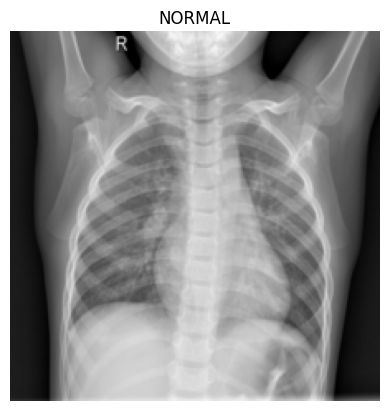

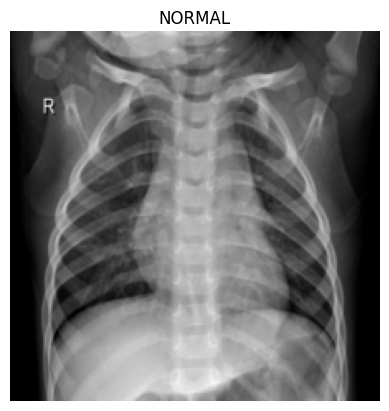

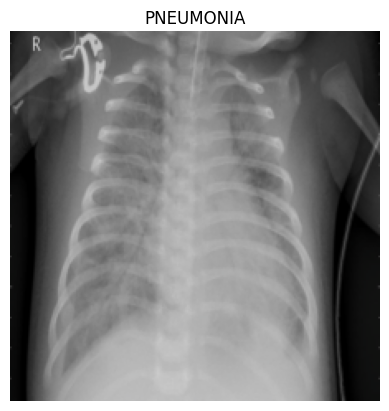

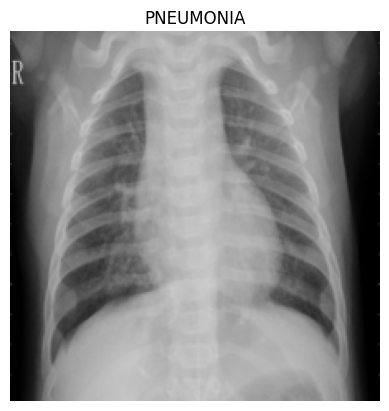

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show a single image
def imshow(img, label):
    img = img.numpy().transpose((1,2,0))
    mean = np.array([0.485,0.456,0.406])
    std = np.array([0.229,0.224,0.225])
    img = std*img + mean
    img = np.clip(img,0,1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
    plt.show()

# Collect 2 images per class
samples = {'NORMAL': [], 'PNEUMONIA': []}
for img, label in train_data:
    class_name = train_data.classes[label]
    if len(samples[class_name]) < 2:
        samples[class_name].append(img)
    if all(len(v)==2 for v in samples.values()):
        break

# Display images
for class_name, imgs in samples.items():
    for img in imgs:
        imshow(img, class_name)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PneumoniaCNN(nn.Module):
    def __init__(self):
        super(PneumoniaCNN,self).__init__()
        self.conv1 = nn.Conv2d(3,16,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3,padding=1)
        self.fc1 = nn.Linear(32*56*56,128)
        self.fc2 = nn.Linear(128,2)
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1,32*56*56)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PneumoniaCNN().to(device)
print(model)


PneumoniaCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 3

for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss/len(train_loader):.4f}")

print("Training completed.")


Epoch [1/3] - Loss: 0.1688
Epoch [2/3] - Loss: 0.0736
Epoch [3/3] - Loss: 0.0448
Training completed.


Test Accuracy: 74.36%
Classification Report:
              precision    recall  f1-score   support

      NORMAL       0.97      0.32      0.49       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624

Confusion Matrix:
[[ 76 158]
 [  2 388]]


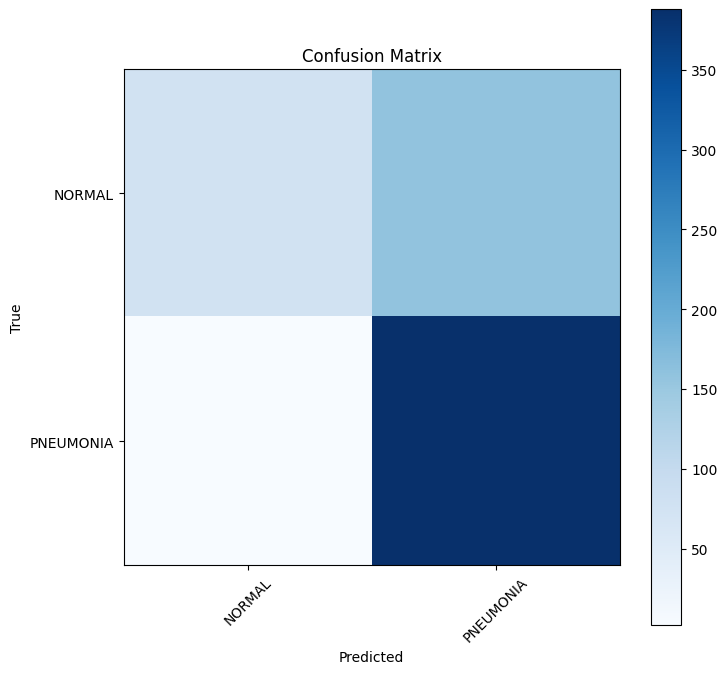

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

test_data = datasets.ImageFolder(os.path.join(data_dir,'test'), transform=transform)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=train_data.classes))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

plt.figure(figsize=(8,8))
plt.imshow(confusion_matrix(all_labels, all_preds), interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(train_data.classes))
plt.xticks(tick_marks, train_data.classes, rotation=45)
plt.yticks(tick_marks, train_data.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
